In [23]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [24]:
from sklearn.datasets import load_diabetes

Создадим собственный алгоритм реализации решающего дерева

In [25]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [26]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, values):
        self.data = data
        self.values = values
        
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет среднего в листе
        prediction = np.mean(self.values)
        return prediction

In [27]:
class RegressionTree:

    def __init__(self, max_depth=10000, max_leaves=10000, min_leaf =1):
        self.max_depth = max_depth
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaves
        self.min_leaf = min_leaf
        self.tree = None

    def dispersion (self, values):  # Расчет значения дисперсии в узле
        dispersion = np.std(values)
        return dispersion

   
    def quality(self, left_values, right_values, current_dispersion):  # Расчет качества 

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_values.shape[0]) / (left_values.shape[0] + right_values.shape[0])

        return current_dispersion - p * self.dispersion(left_values) - (1 - p) * self.dispersion(right_values)

  
    def split(self, data, values, index, t):  # Разбиение датасета в узле

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_values = values[left]
        false_values = values[right]

        return true_data, false_data, true_values, false_values

    def find_best_split(self, data, values):  # Нахождение наилучшего разбиения


        current_dispersion = self.dispersion(values)
        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            t_values = [row[index] for row in data]

            for t in t_values:
                true_data, false_data, true_values, false_values = self.split(data, values, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_values, false_values, current_dispersion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, values):

        quality, t, index = self.find_best_split(data, values)
        

        # Базовый случай (3) - прекращаем рекурсию, когда достигнута максимальное число листьев
        if len(self.leaves) >= self.max_leaves - 1:
            self.leaves.append(Leaf(data, values))
            return Leaf(data, values)

        # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
        if self.depth >= self.max_depth:
            self.leaves.append(Leaf(data, values))
            return Leaf(data, values)

        self.depth += 1

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            self.leaves.append(Leaf(data, values))
            return Leaf(data, values)

        true_data, false_data, true_values, false_values = self.split(data, values, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_values)
        false_branch = self.build_tree(false_data, false_values)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def fit(self, data, values):
        self.tree = self.build_tree(data, values)
        return self

    def predict(self, data):

        val = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            val.append(prediction)

        return val


In [28]:
X, y = load_diabetes(return_X_y=True)

In [29]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем градиентный бустинг на решающих деревьев. По выбору можно задать, на какой основе строить бустинг - либо на стандартном дереве sklearn, либо на основе собственного дерева. По умолчанию - sklearn

In [30]:
class GradientBoosting:
    
    def __init__(self, n_trees, coefs,
                 max_depth=100,
                 max_leaf_nodes=200,
                 min_leaf=1,
                 eta = 1,
                 algorythm = 'sklearn'):
        self.n_trees = n_trees #число деревьев в ансабле
        self.max_depth = max_depth #ограничение максимальной глубины деревьев в ансабле
        self.max_leaf_nodes = max_leaf_nodes #ограничение максимального числа листьев в деревьях
        self.min_leaf = min_leaf #ограничние минимльного количества объектов в листе
        self.eta =eta # шаг градиентного бустинга
        self.algorythm = algorythm #алгоритм реализации решающего дерева
        self.trees_list = [] #список деревьев в ансабле
        self.coefs = coefs # список коэфицинтов 
        self.trees_predicts=[]
        self.bootstrap = []
        self.sample_indexes = None

    
    
    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta* coef * alg.predict([x])[0] for alg, coef in zip(self.trees_list, self.coefs)]) for x in X])
    
    def mean_squared_error(self, y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)

    def bias(self, y, z):
        return (y - z)
    
    def fit(self, X_train, X_test, y_train, y_test):
    
        # Деревья будем записывать в список
        self.trees_list = []
    
        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        train_errors = []
        test_errors = []

        for i in range(self.n_trees):
            if self.algorythm =='sklearn':
                tree = DecisionTreeRegressor(max_depth=self.max_depth,  random_state=42)
            elif self.algorythm =='my_tree':
                tree = RegressionTree(max_depth=self.max_depth)
            else:
                print ("Выберите либо алгоритм sklearn, либо my_tree")
                break
                

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees_list) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)

                train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_train)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train, target))

                train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))

            self.trees_list.append(tree)

        return self.trees_list, train_errors, test_errors


In [31]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1
gb=GradientBoosting(n_trees=n_trees, max_depth=max_depth,eta=eta, coefs=coefs)
trees, train_errors, test_errors= gb.fit(X_train, X_test, y_train, y_test) 


In [32]:
def evaluate_alg(X_train, X_test, y_train, y_test, alg):
    train_prediction = alg.predict(X_train)

    print(f'Ошибка алгоритма из {alg.n_trees} деревьев глубиной {alg.max_depth} \
    с шагом {alg.eta} на тренировочной выборке: {alg.mean_squared_error(y_train, train_prediction)}')

    test_prediction = alg.predict(X_test)

    print(f'Ошибка алгоритма из {alg.n_trees} деревьев глубиной {alg.max_depth} \
    с шагом {alg.eta} на тестовой выборке: {alg.mean_squared_error(y_test, test_prediction)}')

In [33]:
evaluate_alg(X_train, X_test, y_train, y_test, gb)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1108.02187541606
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4453.139366017513


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [34]:
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams["figure.figsize"] = 15, 9

In [35]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

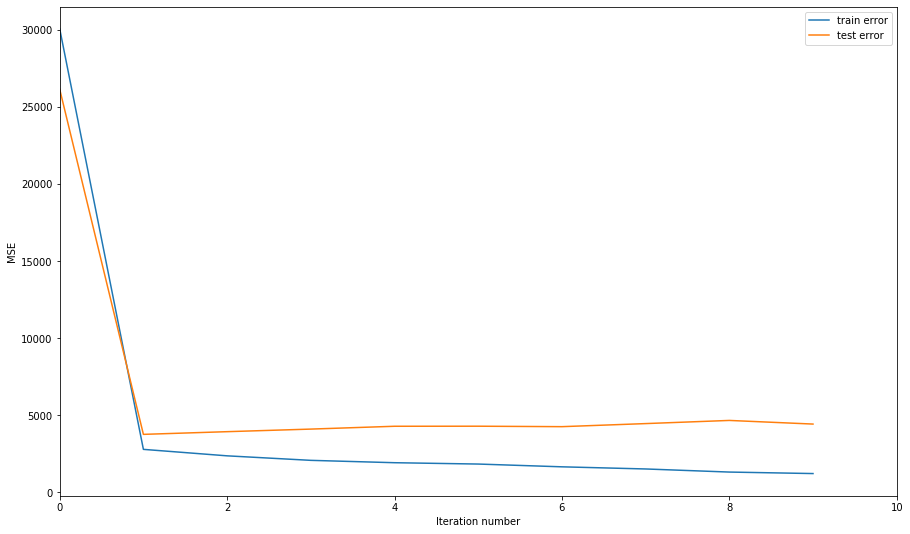

In [36]:
get_error_plot(n_trees, train_errors, test_errors)

**ДЗ-1**
Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

Будем увеличивать число деревьев, изучая, как изменяется ошибка

In [37]:
eta=1
max_depth=3

trees_number = [10, 50, 70, 100, 150]

In [38]:
errors_train = []
errors_test = []
for n_trees in trees_number:
    coefs = [1] * n_trees
    alg=GradientBoosting(n_trees=n_trees, max_depth=max_depth,eta=eta, coefs=coefs)
    trees, train_errors, test_errors= alg.fit(X_train, X_test, y_train, y_test) 
    train_prediction = alg.predict(X_train)
    test_prediction = alg.predict(X_test)
    errors_train.append(alg.mean_squared_error(y_train, train_prediction))
    errors_test.append(alg.mean_squared_error(y_test, test_prediction))
    
    
    
    

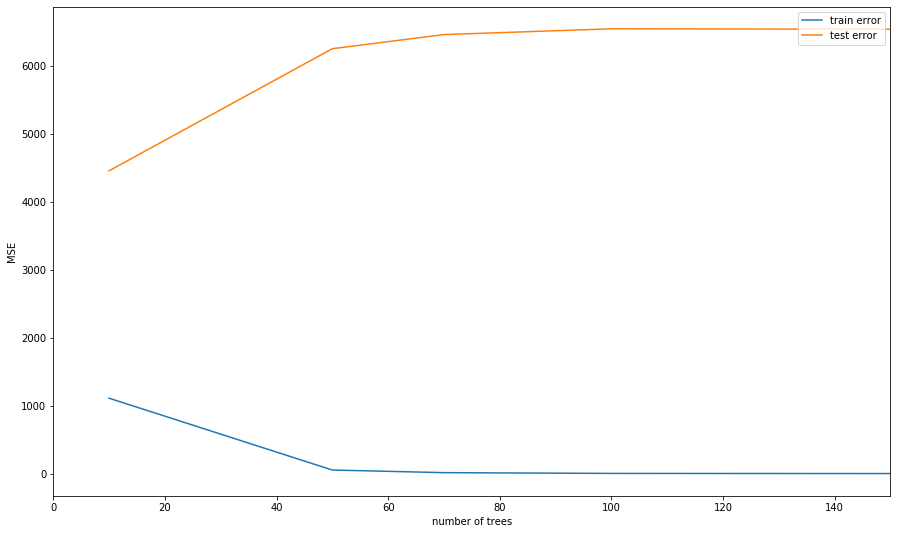

In [39]:

from pylab import rcParams
rcParams["figure.figsize"] = 15, 9
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(trees_number, errors_train, label='train error')
plt.plot(trees_number, errors_test, label='test error')
plt.legend(loc='upper right')
plt.show()

Вывод: при увеличении количества деревьев примерно до 50, ошибка на тренировочной выборке резко снижается, а на тестовой также резко возрастает, имеет место переобучение. Далее величины ошибк практически не изменяются

Изучим, как влияет изменение глубины деревьев на ошибку

In [11]:
depth = [1,2,3,4,5,6,7,10,15,20,30,50]
n_trees = 10
eta=1

In [12]:
errors_train_sklearn = []
errors_test_sklearn = []
for max_depth in depth:
    coefs = [1] * n_trees
    alg_sklearn=GradientBoosting(n_trees=n_trees, max_depth=max_depth,eta=eta, coefs=coefs)
    trees, train_errors, test_errors= alg_sklearn.fit(X_train, X_test, y_train, y_test) 
    train_prediction = alg_sklearn.predict(X_train)
    test_prediction = alg_sklearn.predict(X_test)
    errors_train_sklearn.append(alg_sklearn.mean_squared_error(y_train, train_prediction))
    errors_test_sklearn.append(alg_sklearn.mean_squared_error(y_test, test_prediction))

3*. Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [13]:
depth = [1,2,3,4,5,6,7,10,15,20,30,50]
n_trees = 10
eta=1

In [14]:
errors_train_my_tree = []
errors_test_my_tree = []
for max_depth in depth:
    coefs = [1] * n_trees
    alg_my_tree=GradientBoosting(n_trees=n_trees, max_depth=max_depth, algorythm = 'my_tree', eta=eta, coefs=coefs)
    trees, train_errors, test_errors= alg_my_tree.fit(X_train, X_test, y_train, y_test) 
    train_prediction = alg_my_tree.predict(X_train)
    test_prediction = alg_my_tree.predict(X_test)
    errors_train_my_tree.append(alg_my_tree.mean_squared_error(y_train, train_prediction))
    errors_test_my_tree.append(alg_my_tree.mean_squared_error(y_test, test_prediction))
    

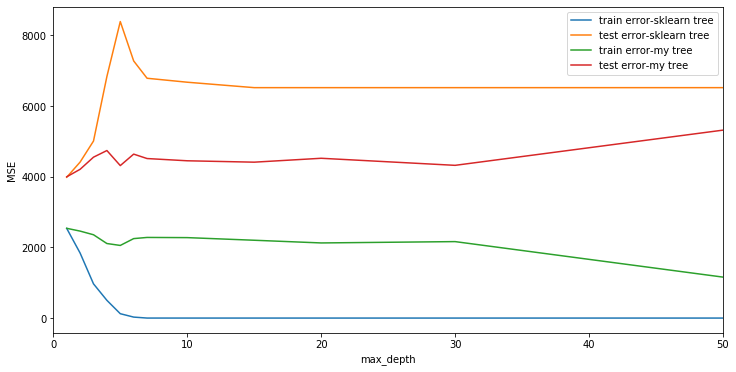

In [22]:
rcParams["figure.figsize"] = 12, 6
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.xlim(0, max(depth))
plt.plot(depth, errors_train_sklearn, label='train error-sklearn tree')
plt.plot(depth, errors_test_sklearn, label='test error-sklearn tree')
plt.plot(depth, errors_train_my_tree, label='train error-my tree')
plt.plot(depth, errors_test_my_tree, label='test error-my tree')
plt.legend(loc='upper right')
plt.show()

Вывод: алгоритм на основании собственного алгоритма решающего дерева в сравнении с деревом из sklearn демонстрирует более ввысокую ошибку на тренировочной выборке и более низкую на тестовой при увеличении глубины деревьев
